# 1 Finding Concurrent ECOSTRESS and EMIT Data

**Summary**  

Both the ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station (ECOSTRESS) and the Earth surface Mineral dust source InvesTigation (EMIT) instruments are located on the International Space Station (ISS). Their overlapping fields of view provide an unprecedented opportunity to demonstrate the compounded benefits of working with both datasets. In this notebook we will show how to utilize the [`earthaccess` Python library](https://github.com/nsidc/earthaccess) to find concurrent ECOSTRESS and EMIT data. 

<div>
<img src="../img/concurrent_data.png" width="750"/>
</div>

**Background**

The **ECOSTRESS** instrument is a multispectral thermal imaging radiometer designed to answer three overarching science questions:

- How is the terrestrial biosphere responding to changes in water availability?
- How do changes in diurnal vegetation water stress  the global carbon cycle?
- Can agricultural vulnerability be reduced through advanced monitoring of agricultural water consumptive use and improved drought   estimation?

The ECOSTRESS mission is answering these questions by accurately measuring the temperature of plants.  Plants regulate their temperature by releasing water through tiny pores on their leaves called stomata. If they have sufficient water they can maintain their temperature, but if there is insufficient water, their temperatures rise and this temperature rise can be measured with ECOSTRESS. The images acquired by ECOSTRESS are the most detailed temperature images of the surface ever acquired from space and can be used to measure the temperature of an individual farmers field.

More details about ECOSTRESS and its associated products can be found on the [ECOSTRESS website](https://ecostress.jpl.nasa.gov/) and [ECOSTRESS product pages](https://lpdaac.usgs.gov/product_search/?query=ECOSTRESS&status=Operational&view=cards&sort=title) hosted by the Land Processes Distributed Active Archive Center (LP DAAC).

The **EMIT** instrument is an imaging spectrometer that measures light in visible and infrared wavelengths. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. In addition, the EMIT instrument can be used in other applications, such as mapping of greenhouse gases, snow properties, and water resources.

More details about EMIT and its associated products can be found on the [EMIT website](https://earth.jpl.nasa.gov/emit/) and [EMIT product pages](https://lpdaac.usgs.gov/product_search/?query=EMIT&status=Operational&view=cards&sort=title) hosted by the LP DAAC.

**Requirements**  
 - [NASA Earthdata Account](https://urs.earthdata.nasa.gov/home)   
 - *No Python setup requirements if connected to the workshop cloud instance!*  
 - **Local Only** Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder to set up a local compatible Python environment 

**Learning Objectives**  
- How to use `earthaccess` to find concurrent EMIT and ECOSTRESS data.  
- How to export a list of files and download them programmatically.  

**Tutorial Outline**  

1. Setup
2. Searching for EMIT and ECOSTRESS Data
3. Organizing and Filtering Results
4. Visualizing Intersecting Coverage
5. Creating a list of Results and Desired Asset URLs
6. Streaming or Downloading Data

## 1. Setup

Import the required Python libraries.

In [1]:
# Import required libraries
import os
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

### 1.2 NASA Earthdata Login Credentials

To download or stream NASA data you will need an Earthdata account, you can create one [here](https://urs.earthdata.nasa.gov/home). We will use the `login` function from the `earthaccess` library for authentication before downloading at the end of the notebook. This function can also be used to create a local `.netrc` file if it doesn't exist or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. This step is not necessary to conduct searches but is needed to download or stream data.

## 2. Search for ECOSTRESS and EMIT Data

Both EMIT and ECOSTRESS products are hosted by the Land Processes Distributed Active Archive Center (LP DAAC). In this example we will use the cloud-hosted EMIT_L2A_RFL and ECOSTRESS_L2T_LSTE products available from the LP DAAC to find data. Any results we find for these products, should be available for other products within the EMIT and ECOSTRESS collections. 

To find data we will use the [`earthaccess` Python library](https://github.com/nsidc/earthaccess). `earthaccess` searches NASA's Common Metadata Repository (CMR), a metadata system that catalogs Earth Science data and associated metadata records. The results can then be used to download granules or generate lists of granule search result URLs.

Using `earthaccess` we can search based on the attributes of a granule, which can be thought of as a spatiotemporal scene from an instrument containing multiple assets (ex: Reflectance, Reflectance Uncertainty, Masks for the EMIT L2A Reflectance Collection). We can search using attributes such as collection, acquisition time, and spatial footprint. This process can also be used with other EMIT or ECOSTRESS products, other collections, or different data providers, as well as across multiple catalogs with some modification. 

### 2.1 Define Spatial Region of Interest

For this example, our spatial region of interest (ROI) will be the a region near Santa Barbara, CA that contains the [Jack and Laura Dangermond Preserve](https://www.dangermondpreserve.org/) and the [Sedgwick Reserve](https://sedgwick.nrs.ucsb.edu/). 

In this example, we will create a rectangular ROI surrounding these two reserves as well as some of the agricultural region between. Even though the shape is rectangular we elect to search using a polygon rather than a standard bounding box in `earthaccess` because bounding boxes will typically have a larger spatial extent, capturing a lot of area we may not be interested in. This becomes more important for searches with larger ROIs than our example here. To search for intersections with a polygon using earthaccess, we need to format our ROI as a counterclockwise list of coordinate pairs. 

Open the `geojson` file containing the Dangermond and Sedgwick boundaries as a `geodataframe`, and check the coordinate reference system (CRS) of the data.

In [2]:
polygon = gpd.read_file('../data/agu_workshop_roi.geojson')
polygon.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS is **EPSG:4326** (WGS84), which is also the CRS we want the data in to submit for our search.

Next, let's examine our polygon a bit closer.

In [3]:
polygon

,Name,Acreage,geometry
0,Sedgwick Reserve,5874.210000,"POLYGON ((-120.04041 34.74342, -120.04122 34.7..."
1,Dangermond Preserve,24458.615397,"POLYGON ((-120.47367 34.56987, -120.47427 34.5..."


We can see this `geodataframe` consists of two polygons, that we want to include in our study site. We need to create an exterior boundary polygon containing these, and make sure the vertices are in counterclockwise order to submit them in our query. To do this, create a polygon consisting of all the geometries, then create a bounding rectangle. This will give us a simple exterior polygon around our two ROIs. After that, use the `orient` function to place our coordinate pairs in counterclockwise order.

In [4]:
# Merge all Polygon geometries and create external boundary
roi_poly = polygon.unary_union.envelope
# Re-order vertices to counterclockwise
roi_poly = orient(roi_poly, sign=1.0)

Make a `GeoDataFrame` consisting of the bounding box geometry.

In [5]:
df = pd.DataFrame({"Name":["ROI Bounding Box"]})
agu_bbox = gpd.GeoDataFrame({"Name":["ROI Bounding Box"], "geometry":[roi_poly]},crs="EPSG:4326")
agu_bbox

,Name,geometry
0,ROI Bounding Box,"POLYGON ((-120.49929 34.44230, -120.01175 34.4..."


We can write this bounding box to a file for use in future notebooks.

In [6]:
#agu_bbox.to_file('../data/roi_bbox.geojson', driver='GeoJSON')

We can go ahead and visualize our region of interest and the exterior boundary polygon containing ROIs. First add a function to help reformat bounding box coordinates to work with leaflet notation.

In [7]:
# Function to convert a bounding box for use in leaflet notation

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [8]:
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add Convex Hull Polygon
folium.GeoJson(agu_bbox,
                name='bounding_box',
                ).add_to(map1)

# Add roi geodataframe
polygon.explore(
    "Name",
    popup=True,
    categorical=True,
    cmap='Set3',
    style_kwds=dict(opacity=0.7, fillOpacity=0.4),
    name="Regions of Interest",
    m=map1
)

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(polygon.unary_union.bounds))
display(fig)

Above we can see our regions of interest (ROIs) and the exterior boundary polygon containing the ROIs that we opened. We can hover over different areas to see the name of each ROI.

Lastly, we need to convert our polygon to a list of coordinate pairs, so it will be accepted as a 'polygon' search parameter in `earthaccess`, as it expects a list of coordinate pairs in a counterclockwise order.

In [9]:
# Set ROI as list of exterior polygon vertices as coordinate pairs
roi = list(roi_poly.exterior.coords)

### 2.2 Define Collections of Interest

We need to specify which products we want to search for. The best way to do this is using their concept-id. As mentioned above, we will conduct our search using the EMIT Level 2A Reflectance (EMITL2ARFL) and ECOSTRESS Level 2 Tiled Land Surface Temperature and Emissivity (ECO_L2T_LSTE). We can do some quick collection queries using `earthaccess` to retrieve the concept-id for each dataset. 

>Note: Here we use the Tiled ECOSTRESS LSTE Product. This will also work with the gridded LSTE and the swath; however, the swath product does not have a browse image for the visualization in section 4 and will require additional processing for subsequent analysis.

In [10]:
# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2A Reflectance')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2408750690-LPCLOUD",
     "granule-count": 80543,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2ARFL",
     "EntryTitle": "EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001",
     "Version": "001"
   }
 }]

In [11]:
# ECOSTRESS Collection Query
eco_collection_query = earthaccess.collection_query().keyword('ECOSTRESS L2 Tiled LSTE')
eco_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2076090826-LPCLOUD",
     "granule-count": 3133795,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "ECO_L2T_LSTE",
     "EntryTitle": "ECOSTRESS Tiled Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002",
     "Version": "002"
   }
 },
 {
   "meta": {
     "concept-id": "C2204557047-LPDAAC_ECS",
     "granule-count": 1761265,
     "provider-id": "LPDAAC_ECS"
   },
   "umm": {
     "ShortName": "ECO_L2T_LSTE",
     "EntryTitle": "ECOSTRESS Tiled Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002",
     "Version": "002"
   }
 },
 {
   "meta": {
     "concept-id": "C2090073749-LPCLOUD",
     "granule-count": 202814,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "ECO_L2T_STARS",
     "EntryTitle": "ECOSTRESS Tiled Ancillary NDVI and Albedo L2 Global 70 m V002",
     "Version": "002"
   }
 }]

If your search returns multiple products, be sure to select the right concept-id For this example it will be the first one. We want to use the `LPCLOUD` ECOSTRESS Tiled Land Surface Temperature and Emissivity (concept-id: "C2076090826-LPCLOUD"). Create a list of these concept-ids for our data search.

In [12]:
# Data Collections for our search
concept_ids = ['C2408750690-LPCLOUD', 'C2076090826-LPCLOUD']

### 2.3 Define Date Range

For our date range, we'll look at data collected between January and October 2023. The `date_range` can be specified as a pair of dates, start and end (up to, not including).

In [13]:
# Define Date Range
date_range = ('2023-01-01','2023-11-01')

### 2.4 Searching

Submit a query using `earthaccess`.

In [14]:
results = earthaccess.search_data(
    concept_id=concept_ids,
    polygon=roi,
    temporal=date_range,
    count=500
)

Granules found: 323



## 3. Organizing and Filtering Results

As we can see from above, the results object contains a list of objects with metadata and links. We can convert this to a more readable format, a dataframe. In addition, we can make it a geodataframe by taking the spatial metadata and creating a shapely polygon representing the spatial coverage, and further customize which information we want to use from other metadata fields.

First, we define some functions to help us create a shapely object for our geodataframe, and retrieve the specific browse image URLs that we want. By default, the browse image selected by `earthaccess` is the first one in the list, but the ECO_L2_LSTE has several browse images, and we want to make sure we retrieve the `png` file, which is a preview of the LSTE.

In [15]:
# Function to create shapely polygon of spatial coverage
def get_shapely_object(result:earthaccess.results.DataGranule):
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                    bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

Now that we have our functions we can create a dataframe, then calculate and add our shapely geometries to make a geodataframe. After that, add a column for our browse image urls and print the number of granules in our results, so we can monitor the quantity we  are working with a we winnow down to the data we want.

In [16]:
# Create Dataframe of Results Metadata
results_df = pd.json_normalize(results)
# Create shapely polygons for result
geometries = [get_shapely_object(results[index]) for index in results_df.index.to_list()]
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(results_df, geometry=geometries, crs="EPSG:4326")
# Remove results df, no longer needed
del results_df
# Add browse imagery links
gdf['browse'] = [get_png(granule) for granule in results]
gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in results]
# Preview GeoDataframe
print(f'{gdf.shape[0]} granules total')

323 granules total


Preview our geodataframe to get an idea what it looks like.

In [17]:
gdf.head()

,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,...,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons,umm.PGEVersionClass.PGEName,umm.CloudCover,geometry,browse,shortname
0,2.496260,granule,G2581836170-LPCLOUD,2,ECOv002_L2T_LSTE_25460_016_11SKU_20230101T1552...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2024-01-20T15:57:11.266Z,2023-01-01T15:52:48.650Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
1,0.292531,granule,G2586136519-LPCLOUD,2,ECOv002_L2T_LSTE_25486_005_10SGD_20230103T0743...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2024-01-20T17:35:56.995Z,2023-01-03T07:43:30.510Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
2,8.495430,granule,G2586136993-LPCLOUD,2,ECOv002_L2T_LSTE_25486_006_11SKU_20230103T0744...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2024-01-20T17:36:01.364Z,2023-01-03T07:44:22.480Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
3,5.103070,granule,G2586137000-LPCLOUD,2,ECOv002_L2T_LSTE_25486_006_10SGD_20230103T0744...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2024-01-20T17:36:08.168Z,2023-01-03T07:44:22.480Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
4,1.160680,granule,G2591892077-LPCLOUD,2,ECOv002_L2T_LSTE_25547_005_11SKU_20230107T0607...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2024-01-17T16:14:22.254Z,2023-01-07T06:07:21.560Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE


There are a lot of columns with data that is not relevant to our goal, so we can drop those. To do that, list the names of columns.

In [18]:
# List Column Names
gdf.columns

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime',
       'umm.OrbitCalculatedSpatialDomains', 'umm.GranuleUR',
       'umm.AdditionalAttributes', 'umm.MeasuredParameters',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.BoundingRectangles',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEVersion',
       'umm.RelatedUrls', 'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version',
       'umm.Spa

Now create a list of columns to keep and use it to filter the dataframe.

In [19]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
gdf = gdf[gdf.columns.intersection(keep_cols)]
gdf.head()

,meta.concept-id,meta.native-id,umm.TemporalExtent.RangeDateTime.BeginningDateTime,umm.TemporalExtent.RangeDateTime.EndingDateTime,umm.DataGranule.DayNightFlag,umm.CloudCover,geometry,browse,shortname
0,G2581836170-LPCLOUD,ECOv002_L2T_LSTE_25460_016_11SKU_20230101T1552...,2023-01-01T15:52:48.650Z,2023-01-01T15:53:40.620Z,Day,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
1,G2586136519-LPCLOUD,ECOv002_L2T_LSTE_25486_005_10SGD_20230103T0743...,2023-01-03T07:43:30.510Z,2023-01-03T07:44:22.480Z,Night,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
2,G2586136993-LPCLOUD,ECOv002_L2T_LSTE_25486_006_11SKU_20230103T0744...,2023-01-03T07:44:22.480Z,2023-01-03T07:45:14.450Z,Night,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
3,G2586137000-LPCLOUD,ECOv002_L2T_LSTE_25486_006_10SGD_20230103T0744...,2023-01-03T07:44:22.480Z,2023-01-03T07:45:14.450Z,Night,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
4,G2591892077-LPCLOUD,ECOv002_L2T_LSTE_25547_005_11SKU_20230107T0607...,2023-01-07T06:07:21.560Z,2023-01-07T06:08:13.530Z,Night,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE


This is looking better, but we can make it more readable by renaming our columns.

In [20]:
# Rename some Columns
gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                       'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                      'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                      'umm.CloudCover':'cloud_cover',
                      'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
gdf.head()

,concept_id,granule,start_datetime,end_datetime,day_night,cloud_cover,geometry,browse,shortname
0,G2581836170-LPCLOUD,ECOv002_L2T_LSTE_25460_016_11SKU_20230101T1552...,2023-01-01T15:52:48.650Z,2023-01-01T15:53:40.620Z,Day,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
1,G2586136519-LPCLOUD,ECOv002_L2T_LSTE_25486_005_10SGD_20230103T0743...,2023-01-03T07:43:30.510Z,2023-01-03T07:44:22.480Z,Night,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
2,G2586136993-LPCLOUD,ECOv002_L2T_LSTE_25486_006_11SKU_20230103T0744...,2023-01-03T07:44:22.480Z,2023-01-03T07:45:14.450Z,Night,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
3,G2586137000-LPCLOUD,ECOv002_L2T_LSTE_25486_006_10SGD_20230103T0744...,2023-01-03T07:44:22.480Z,2023-01-03T07:45:14.450Z,Night,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
4,G2591892077-LPCLOUD,ECOv002_L2T_LSTE_25547_005_11SKU_20230107T0607...,2023-01-07T06:07:21.560Z,2023-01-07T06:08:13.530Z,Night,NaN,"POLYGON ((-119.06582 34.21003, -119.06582 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE


> **Note: If querying on-premises (not cloud) LP DAAC datasets, the `meta.concept-id` will not show as `xxxxxx-LPCLOUD`. For these datasets, the granule name can be retrieved from the `umm.DataGranule.Identifiers` column.**

We can filter using the day/night flag as well, but this step will be unnecessary as we check to ensure all results from ECOSTRESS fall within an hour of resulting EMIT granules.

In [21]:
# gdf = gdf[gdf['day_night'].str.contains('Day')]

Our first step toward filtering the datasets will be to add a column with a `datetime`. 

> **You may have noticed that the date format is similar for ECOSTRESS and EMIT, but the ECOSTRESS data also includes fractional seconds. If using an different version of `pandas`, you may need to drop the `format='ISO8601'`argument to the `to_datetime` function, as shown in the commented-out line.**

In [22]:
# gdf['datetime_obj'] = pd.to_datetime(gdf['start_datetime']) # different pandas version
gdf['datetime_obj'] = pd.to_datetime(gdf['start_datetime'], format='ISO8601')

We can roughly visualize the quantity of results by month at our location using a histogram with 8 bins (Jan - Oct).

array([<Axes: title={'center': 'ECO_L2T_LSTE'}>,
       <Axes: title={'center': 'EMITL2ARFL'}>], dtype=object)

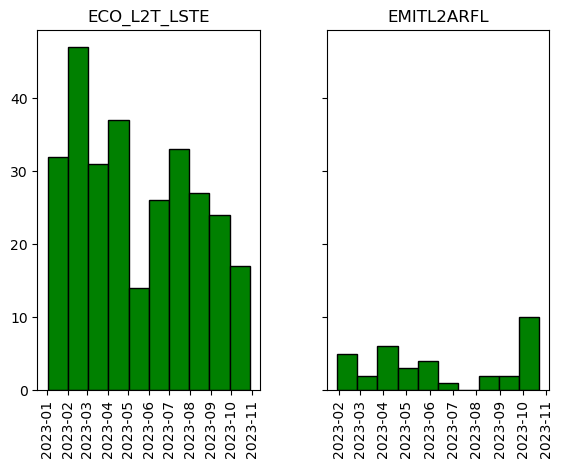

In [23]:
gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True)

Now we will separate the results into two dataframes, one for ECOTRESS and one for EMIT, and print the number of results for each so we can monitor how many granules we're filtering.

In [24]:
# Suppress Setting with Copy Warning - not applicable in this use case
pd.options.mode.chained_assignment = None  # default='warn'

# Split into two dataframes - ECO and EMIT
eco_gdf = gdf[gdf['granule'].str.contains('ECO')]
emit_gdf = gdf[gdf['granule'].str.contains('EMIT')]
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 288 
 EMIT Granules: 35


In [25]:
emit_gdf.head()

,concept_id,granule,start_datetime,end_datetime,day_night,cloud_cover,geometry,browse,shortname,datetime_obj
31,G2623634492-LPCLOUD,EMIT_L2A_RFL_001_20230129T211308_2302914_003,2023-01-29T21:13:08Z,2023-01-29T21:13:20Z,Day,96.0,"POLYGON ((-120.29004 35.49324, -121.08087 34.8...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-01-29 21:13:08+00:00
53,G2631040813-LPCLOUD,EMIT_L2A_RFL_001_20230219T202939_2305013_002,2023-02-19T20:29:39Z,2023-02-19T20:29:51Z,Day,47.0,"POLYGON ((-120.70791 35.54348, -121.19894 34.9...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-19 20:29:39+00:00
56,G2631045418-LPCLOUD,EMIT_L2A_RFL_001_20230219T202951_2305013_003,2023-02-19T20:29:51Z,2023-02-19T20:30:14Z,Day,67.0,"POLYGON ((-120.04838 35.03646, -120.54523 34.4...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-19 20:29:51+00:00
65,G2631457332-LPCLOUD,EMIT_L2A_RFL_001_20230223T185536_2305412_003,2023-02-23T18:55:36Z,2023-02-23T18:55:48Z,Day,98.0,"POLYGON ((-120.61175 35.58776, -121.10041 34.9...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-23 18:55:36+00:00
66,G2631458885-LPCLOUD,EMIT_L2A_RFL_001_20230223T185548_2305412_004,2023-02-23T18:55:48Z,2023-02-23T18:56:00Z,Day,96.0,"POLYGON ((-119.95147 35.08163, -120.44685 34.4...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-23 18:55:48+00:00


We still haven't filtered the locations where EMIT and ECOSTRESS have data at the same spatial location and timeframe. The EMIT acquisition mask has been added to ECOSTRESS, so in most cases if EMIT is collecting data, so will ECOSTRESS, but there are edge cases where this is not true.  To do this we'll use two filters to catch the edge-cases and provide an example that can be used with other datasets. 

First, since EMIT has a smaller swath width, we can use a unary union of the spatial coverage present in our geodataframe to filter out ECOSTRESS granules that do not overlap with it.

In [26]:
# Subset ECOSTRESS Granules in Geodataframe by intersection with EMIT granules
## Create new column based on intersection with union of EMIT polygons.
eco_gdf['intersects'] = eco_gdf.intersects(emit_gdf.unary_union)
## Apply subsetting
eco_gdf = eco_gdf[eco_gdf['intersects'] == True]
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 288 
 EMIT Granules: 35


In this instance, our results aren't narrowed because our region of interest is smaller than a single EMIT scene. If the spatial ROI was very large, this would be much more unlikely.

Additionally, we want to make sure that data in our results are collected at the same time. For EMIT and ECOSTRESS, the EMIT acquisition mask has been added to the ECOSTRESS mask, meaning that if there is an EMIT scene, there should also be an ECOSTRESS scene acquired at the same time. In practice, however, the timestamps on the scenes can vary slightly. In order to capture this slight variability,  we need to use a range instead of a single timestamp to capture concurrent data. To do this, we'll ensure all ECOSTRESS granule start times fall within 10 minutes of any of the EMIT granules in our results, and vice-versa. 


Write a function to evaluate whether these `datetime` objects fall within 10 minutes of one another using the `timedelta` function.

In [27]:
# Function to Filter timestamps that do not fall within a time_delta of timestamps from the other acquisition time
def concurrent_match(gdf_a:pd.DataFrame, gdf_b:pd.DataFrame, col_name:str, time_delta:timedelta):
    """
    Cross references dataframes containing a datetime object column and keeps rows in 
    each that fall within the provided timedelta of the other. Acceptable time_delta examples:
    
    months=1
    days=1
    hours=1
    minutes=1
    seconds=1 

    """
    # Match Timestamps from Dataframe A with Time-range of entries in Dataframe B
    # Create empty list
    a_list = []
    # Iterate results for product a based on index values
    for _n in gdf_b.index.to_list():
        # Find where product b is within the window of each product a result
        a_matches = (gdf_a[col_name] > gdf_b[col_name][_n]-time_delta) & (gdf_a[col_name] < gdf_b[col_name][_n]+time_delta)
        # Append list with values
        a_list.append(a_matches)
    # Match Timestamps from Dataframe B with Time-range of entries in Dataframe A
    # Create empty list
    b_list =[]
    for _m in gdf_a.index.to_list():
        # Find where product a is within the window of each product b result
        b_matches = (gdf_b[col_name] > gdf_a[col_name][_m]-time_delta) &  (gdf_b[col_name] < gdf_a[col_name][_m]+time_delta)
        # Append list with values
        b_list.append(b_matches)
    # Filter Original Dataframes by summing list of bools, 0 = outside of all time-ranges
    a_filtered = gdf_a.loc[sum(a_list) > 0]
    b_filtered = gdf_b.loc[sum(b_list) > 0]
    return(a_filtered, b_filtered)

Now run our function.

In [28]:
eco_gdf, emit_gdf = concurrent_match(eco_gdf,emit_gdf, col_name='datetime_obj',time_delta=timedelta(minutes=10))
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 32 
 EMIT Granules: 22



## 4. Visualizing Intersecting Coverage

Now that we have geodataframes containing some concurrent data, we can visualize them on a map using `folium`. It's often difficult to visualize a large time-series of scenes, so we've included an example in Appendix A1 on how to filter to a single day.

In [38]:
# Plot Using Folium

# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot STAC ECOSTRESS Results - note we must drop the datetime_obj columns for this to work
eco_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="ECOSTRESS",
    m=map1,
    legend=False
)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

# ECOSTRESS Browse Images - Comment out to remove
for _n in eco_gdf.index.to_list():
    folium.raster_layers.ImageOverlay(
        image=eco_gdf['browse'][_n],
        name=eco_gdf['granule'][_n],
        bounds=[[eco_gdf.bounds['miny'][_n], eco_gdf.bounds['minx'][_n]], [eco_gdf.bounds['maxy'][_n], eco_gdf.bounds['maxx'][_n]]],
        interactive=False,
        cross_origin=False,
        opacity=0.75,
        zindex=1,
        ).add_to(map1)

# Plot Region of Interest
polygon.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

folium.GeoJson(roi_poly,
                name='bounding_box',
                ).add_to(map1)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

In the figure above, you can zoom in and out, and add or remove layers using the layer control in the top right. Notice that since we're using the tiled ECOSTRESS product, we have 2 overlapping tiles at our ROI. You can visualize the tiles by adding or removing the layers.

From this figure, we can see there are two ECOSTRESS tiles: 10SGD and 10SKU, which both intersect with our area. Since both fall within tile 10SGD, we can keep results using 10SGD as a filter.

**There is a lot going on in the above visualization. After doing some additional filtering below, we can re-run the above cell to visualize our filtered scenes.**

In [30]:
eco_gdf = eco_gdf[eco_gdf['granule'].str.contains("10SGD")]

In [31]:
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 17 
 EMIT Granules: 22


### 4.2 Previewing EMIT Browse Imagery
The EMIT browse imagery is not orthorectified, so it can't be visualized on a plot like the ECOSTRESS browse imagery. To get an idea what scenes look like we can plot them in a grid using matplotlib.

> Note: The black space is indicative of onboard cloud masking that occurs before data is downlinked from the ISS.

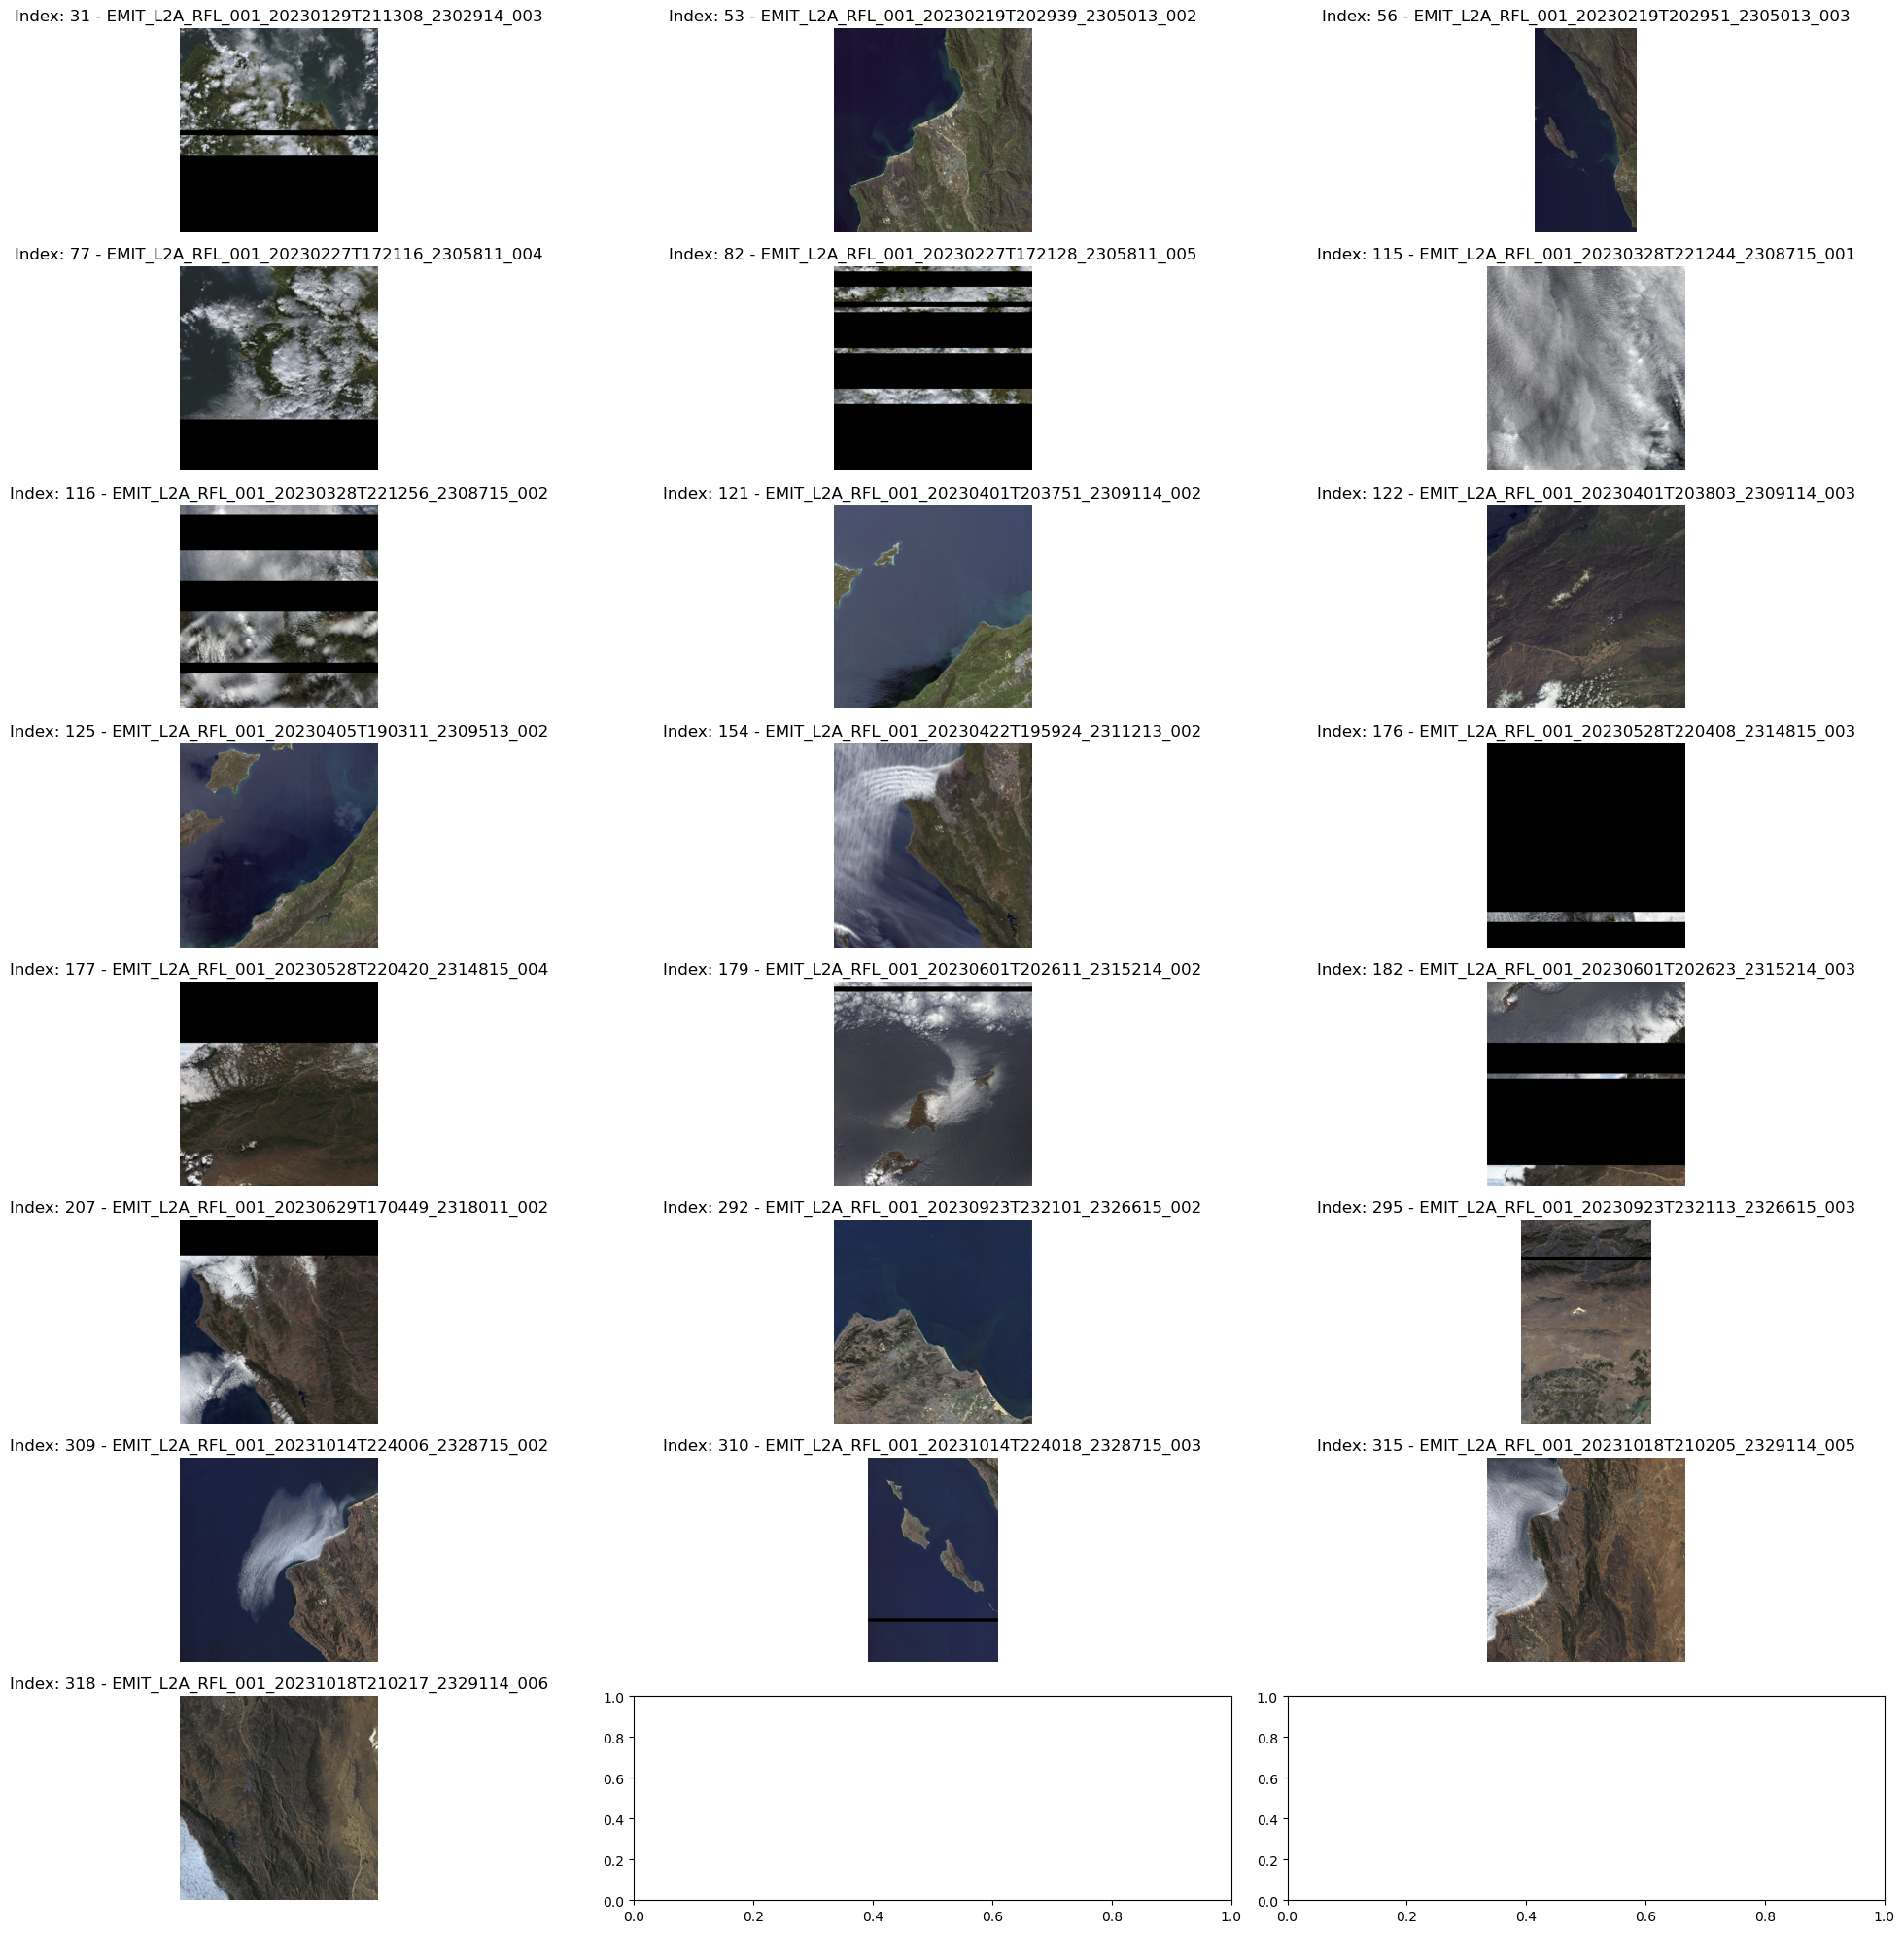

In [32]:
cols = 3
rows = math.ceil(len(emit_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_gdf.index.to_list()):
    img = io.imread(emit_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()

### 4.3 Further Filtering

We can see that some of these granules likely won't work because of the large amount of cloud cover, we can use a list of these to filter them out. Make a list of indexes to filter out. **Note that these indices can change since they are dependent on the order scenes are returned from CMR. Please doublecheck them before running this cell.**

In [33]:
# Bad granule list
bad_granules = [31,82,115,116,176,182]

Filter out the bad granules.

In [34]:
emit_gdf = emit_gdf[~emit_gdf.index.isin(bad_granules)]

Now that we've narrowed our EMIT results we can again filter the ECOSTRESS granules based on their concurrency with our filtered EMIT granules.

In [35]:
eco_gdf, emit_gdf = concurrent_match(eco_gdf,emit_gdf, col_name='datetime_obj',time_delta=timedelta(hours=1))
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 15 
 EMIT Granules: 16


In [36]:
eco_gdf

,concept_id,granule,start_datetime,end_datetime,day_night,cloud_cover,geometry,browse,shortname,datetime_obj,intersects
52,G2627756987-LPCLOUD,ECOv002_L2T_LSTE_26223_011_10SGD_20230219T2028...,2023-02-19T20:28:51.310Z,2023-02-19T20:29:43.280Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-02-19 20:28:51.310000+00:00,True
54,G2627758024-LPCLOUD,ECOv002_L2T_LSTE_26223_012_10SGD_20230219T2029...,2023-02-19T20:29:43.280Z,2023-02-19T20:30:35.250Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-02-19 20:29:43.280000+00:00,True
75,G2630582431-LPCLOUD,ECOv002_L2T_LSTE_26345_013_10SGD_20230227T1720...,2023-02-27T17:20:29.100Z,2023-02-27T17:21:21.070Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-02-27 17:20:29.100000+00:00,True
76,G3015778622-LPCLOUD,ECOv002_L2T_LSTE_26345_013_10SGD_20230227T1720...,2023-02-27T17:20:29.104Z,2023-02-27T17:21:21.074Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-02-27 17:20:29.104000+00:00,True
79,G2630583457-LPCLOUD,ECOv002_L2T_LSTE_26345_014_10SGD_20230227T1721...,2023-02-27T17:21:21.070Z,2023-02-27T17:22:13.040Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-02-27 17:21:21.070000+00:00,True
81,G3015772990-LPCLOUD,ECOv002_L2T_LSTE_26345_014_10SGD_20230227T1721...,2023-02-27T17:21:21.074Z,2023-02-27T17:22:13.044Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-02-27 17:21:21.074000+00:00,True
119,G2650963815-LPCLOUD,ECOv002_L2T_LSTE_26860_001_10SGD_20230401T2037...,2023-04-01T20:37:33.030Z,2023-04-01T20:38:25.000Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-04-01 20:37:33.030000+00:00,True
124,G2655983115-LPCLOUD,ECOv002_L2T_LSTE_26921_001_10SGD_20230405T1902...,2023-04-05T19:02:58.950Z,2023-04-05T19:03:50.920Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-04-05 19:02:58.950000+00:00,True
153,G2710071138-LPCLOUD,ECOv002_L2T_LSTE_27185_010_10SGD_20230422T1958...,2023-04-22T19:58:36.740Z,2023-04-22T19:59:28.710Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-04-22 19:58:36.740000+00:00,True
174,G2715826603-LPCLOUD,ECOv002_L2T_LSTE_27745_005_10SGD_20230528T2204...,2023-05-28T22:04:01.690Z,2023-05-28T22:04:53.660Z,Day,NaN,"POLYGON ((-119.59844 34.20719, -119.59844 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,2023-05-28 22:04:01.690000+00:00,True


In [37]:
emit_gdf

,concept_id,granule,start_datetime,end_datetime,day_night,cloud_cover,geometry,browse,shortname,datetime_obj
53,G2631040813-LPCLOUD,EMIT_L2A_RFL_001_20230219T202939_2305013_002,2023-02-19T20:29:39Z,2023-02-19T20:29:51Z,Day,47.0,"POLYGON ((-120.70791 35.54348, -121.19894 34.9...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-19 20:29:39+00:00
56,G2631045418-LPCLOUD,EMIT_L2A_RFL_001_20230219T202951_2305013_003,2023-02-19T20:29:51Z,2023-02-19T20:30:14Z,Day,67.0,"POLYGON ((-120.04838 35.03646, -120.54523 34.4...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-19 20:29:51+00:00
77,G2631818088-LPCLOUD,EMIT_L2A_RFL_001_20230227T172116_2305811_004,2023-02-27T17:21:16Z,2023-02-27T17:21:28Z,Day,99.0,"POLYGON ((-120.73262 35.83169, -121.21741 35.1...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-02-27 17:21:16+00:00
121,G2648965598-LPCLOUD,EMIT_L2A_RFL_001_20230401T203751_2309114_002,2023-04-01T20:37:51Z,2023-04-01T20:38:03Z,Day,80.0,"POLYGON ((-120.21542 34.90659, -120.99248 34.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-04-01 20:37:51+00:00
122,G2648966116-LPCLOUD,EMIT_L2A_RFL_001_20230401T203803_2309114_003,2023-04-01T20:38:03Z,2023-04-01T20:38:15Z,Day,18.0,"POLYGON ((-119.55793 35.41507, -120.34872 34.7...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-04-01 20:38:03+00:00
125,G2667368816-LPCLOUD,EMIT_L2A_RFL_001_20230405T190311_2309513_002,2023-04-05T19:03:11Z,2023-04-05T19:03:23Z,Day,71.0,"POLYGON ((-119.87804 34.90691, -120.65480 34.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-04-05 19:03:11+00:00
154,G2667503312-LPCLOUD,EMIT_L2A_RFL_001_20230422T195924_2311213_002,2023-04-22T19:59:24Z,2023-04-22T19:59:36Z,Day,40.0,"POLYGON ((-120.49827 35.12071, -120.99520 34.4...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-04-22 19:59:24+00:00
177,G2699997381-LPCLOUD,EMIT_L2A_RFL_001_20230528T220420_2314815_004,2023-05-28T22:04:20Z,2023-05-28T22:04:32Z,Day,52.0,"POLYGON ((-119.96105 35.44150, -120.75292 34.8...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-05-28 22:04:20+00:00
179,G2720810376-LPCLOUD,EMIT_L2A_RFL_001_20230601T202611_2315214_002,2023-06-01T20:26:11Z,2023-06-01T20:26:23Z,Day,15.0,"POLYGON ((-120.29042 34.51665, -120.82317 33.9...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-06-01 20:26:11+00:00
207,G2735424106-LPCLOUD,EMIT_L2A_RFL_001_20230629T170449_2318011_002,2023-06-29T17:04:49Z,2023-06-29T17:05:01Z,Day,48.0,"POLYGON ((-120.35333 35.27559, -120.83881 34.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-06-29 17:04:49+00:00


**We can now go back to our `folium` plot above and  re-run the cell to update it based on our filtering.**


## 5. Generating a list of URLs

With our filtered geodataframe we can go back to our `earthaccess` search results and filter them. 

Create a list of the geodataframe indices to use in filtering our search results.

In [39]:
keep_granules = eco_gdf.index.to_list()+emit_gdf.index.to_list()
keep_granules.sort()

Filter the results list.

In [40]:
filtered_results = [result for i, result in enumerate(results) if i in keep_granules]

After filtering our granules, also want to filter which assets we want from each granule. An asset is an individual file associated with a granule.

Granules often have several assets associated with them, for example, `ECO_L2T_LSTE` has several assets:
 - Water Mask (water)
 - Cloud Mask (cloud)
 - Quality (QC)
 - Land Surface Temperature (LST)
 - Land Surface Temperature Error (LST_err)
 - Wide Band Emissivity (EmisWB)
 - Height (height)

Create a list of results urls from our `filtered_results` list and print the first 5 results.

In [41]:
# Retrieve URLS for Assets
results_urls = [granule.data_links() for granule in filtered_results]

In [42]:
results_urls[:5]

[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01_water.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01_cloud.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01_view_zenith.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01_height.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01/ECOv002_L2T_LSTE_26223

The `results_urls` list we just generated contains URLs for all of these assets nested by granule. We can further filter our these to remove unwanted assets by using string matching.

Create a list of strings and enumerate through our results_url list to filter out unwanted assets and remove the nesting.

In [43]:
filtered_asset_links = []
# Pick Desired Assets (leave _ on RFL to distinguish from RFLUNC, LST. to distinguish from LST_err)
desired_assets = ['_RFL_','_MASK_', 'LST.'] # Add more or do individually for reflectance, reflectance uncertainty, or mask
# Step through each sublist (granule) and filter based on desired assets.
for n, granule in enumerate(results_urls):
    for url in granule: 
        asset_name = url.split('/')[-1]
        if any(asset in asset_name for asset in desired_assets):
            filtered_asset_links.append(url)
# Show first 5 asset links           
filtered_asset_links[:5]

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01/ECOv002_L2T_LSTE_26223_011_10SGD_20230219T202851_0710_01_LST.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230219T202939_2305013_002/EMIT_L2A_RFL_001_20230219T202939_2305013_002.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230219T202939_2305013_002/EMIT_L2A_MASK_001_20230219T202939_2305013_002.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26223_012_10SGD_20230219T202943_0710_01/ECOv002_L2T_LSTE_26223_012_10SGD_20230219T202943_0710_01_LST.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230219T202951_2305013_003/EMIT_L2A_RFL_001_20230219T202951_2305013_003.nc']

Write this list of files to a text file to have a record of the search, or to use for streaming or downloading the data. 

In [44]:
with open('../data/search_results.txt', 'w') as f:
    for line in filtered_asset_links:
        f.write(f"{line}\n")

## 6. Streaming or Downloading Data  

For the workshop, we will stream the data, but either method can be used, and each has trade-offs based on the internet speed, storage space, or use case. The EMIT files are very large due to the number of bands, so operations can take some time if streaming with a slower internet connection. Since the workshop is hosted in a Cloud workspace, we can stream the data directly to the workspace.

### 6.1 Streaming Data Workflow

For an example of streaming both **netCDF** and **Cloud Optimized GeoTIFF (COG) data** please see notebook 2, [Working With EMIT Reflectance and ECOSTRESS LST](02_Working_with_EMIT_Reflectance_and_ECOSTRESS_LST.ipynb).

If you plan to stream the data, you can stop here and move to the next notebook.

### 6.2 Downloading Data Workflow

To download the scenes, we can use the `earthaccess` library to authenticate then download the files.

First, log into Earthdata using the `login` function from the `earthaccess` library. The `persist=True` argument will create a local `.netrc` file if it doesn't exist, or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. As mentioned in section 1.2, this step is not necessary to conduct searches, but is needed to download or stream data.

We've included the canopy water content files in the repository to simplify the notebooks so users don't need to perform that operation for the examples in the repository. This means that only 3 granules from our list are required to execute the notebooks and walk through the notebooks in the repository. These are included in a separate text file, `required_granules.txt`. 

These can be downloading by uncommenting and running the following cells. 

>Note: If interested users can download all of the files using the cell below and recreate all of the canopy water content files following a workflow similar to the example in notebooks 2 and 3 for all of the necessary scenes. To do this, uncomment the `file_list` object with the `search_results.txt` filepath to download all of the results rather than just what is required.

In [45]:
# Authenticate using earthaccess
earthaccess.login(persist=True)

Open the text file containing the URLs you wish to download.

In [ ]:
# # Open Text File and Read Lines
# file_list = '../data/required_granules.txt'
# # file_list = '../data/search_results.txt'
# with open(file_list) as f:
#     urls = [line.rstrip('\n') for line in f]

Download the required granules.

In [ ]:
# # Get requests https Session using Earthdata Login Info
# fs = earthaccess.get_requests_https_session()
# # Retrieve granule asset ID from URL (to maintain existing naming convention)
# for url in urls:
#     granule_asset_id = url.split('/')[-1]
#     # Define Local Filepath
#     fp = f'../data/{granule_asset_id}'
#     # Download the Granule Asset if it doesn't exist
#     if not os.path.isfile(fp):
#         with fs.get(url,stream=True) as src:
#             with open(fp,'wb') as dst:
#                 for chunk in src.iter_content(chunk_size=64*1024*1024):
#                     dst.write(chunk)

Congratulations, now you have downloaded concurrent data from the ECOSTRESS and EMIT instruments on the ISS.


## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 05-17-2024  

¹Work performed under USGS contract 140G0121D0001 for NASA contract NNG14HH33I. 